In [2]:
from matplotlib import pyplot as pl
%matplotlib inline

In [3]:
import pandas as pd
import numpy as np

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, Activation, Flatten, Dense, Dropout
from tensorflow.keras.layers import SimpleRNN, LSTM, RepeatVector, TimeDistributed
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2023-10-11 20:57:11.730330: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-11 20:57:11.827281: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [4]:
non_ringed_curves = np.loadtxt('../../Datasets/curves_1_0.txt')
np.nan_to_num(non_ringed_curves, copy=False)

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

In [11]:
durs = np.loadtxt('../../Datasets/non-ringed-transit-durations.txt')

In [13]:
np.mean(durs)

4.82675

In [5]:
non_ringed_curves_reshaped = non_ringed_curves.reshape((non_ringed_curves.shape[0], non_ringed_curves.shape[1], 1))
index_2_thirds = int((2/3)*non_ringed_curves_reshaped.shape[0])
#index_half = int((1/(2*4))*non_ringed_curves_reshaped.shape[1])
non_ringed_curves_train = non_ringed_curves_reshaped[:index_2_thirds, :4000]

In [6]:
non_ringed_curves_train.shape

(833, 4000, 1)

In [7]:
recurrent_encoder = Sequential([
    LSTM(20, return_sequences=True, input_shape=[non_ringed_curves_train.shape[1],1]),
    LSTM(10)
])
recurrent_decoder = Sequential([
    RepeatVector(non_ringed_curves_train.shape[1], input_shape=[10]),
    LSTM(20, return_sequences=True),
    TimeDistributed(Dense(non_ringed_curves_train.shape[1], activation="linear"))
])
rae_model = Sequential([recurrent_encoder, recurrent_decoder])

2023-10-11 20:57:26.560466: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-11 20:57:26.990982: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22301 MB memory:  -> device: 0, name: NVIDIA RTX A5000, pci bus id: 0000:73:00.0, compute capability: 8.6


In [8]:
rae_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
rae_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 10)                3000      
                                                                 
 sequential_1 (Sequential)   (None, 4000, 4000)        86480     
                                                                 
Total params: 89,480
Trainable params: 89,480
Non-trainable params: 0
_________________________________________________________________


In [9]:
history = rae_model.fit(
    non_ringed_curves_train,
    non_ringed_curves_train,
    epochs=200,
    batch_size=2**7,
    validation_split=0.2,
    callbacks=[
        EarlyStopping(monitor="val_loss", patience=10, mode="min")
    ],
)

Epoch 1/200


2023-10-11 20:57:32.883755: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8401
2023-10-11 20:57:33.173535: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-10-11 20:57:33.415229: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f9d1030e0a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-11 20:57:33.415244: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA RTX A5000, Compute Capability 8.6
2023-10-11 20:57:33.418856: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-11 20:57:33.538016: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the pro

6/6 [==============================] - 8s 637ms/step - loss: 0.9871 - val_loss: 0.9553
Epoch 2/200
6/6 [==============================] - 3s 522ms/step - loss: 0.9268 - val_loss: 0.8608
Epoch 3/200
6/6 [==============================] - 3s 524ms/step - loss: 0.8119 - val_loss: 0.7116
Epoch 4/200
6/6 [==============================] - 3s 522ms/step - loss: 0.6495 - val_loss: 0.5326
Epoch 5/200
6/6 [==============================] - 3s 529ms/step - loss: 0.4700 - val_loss: 0.3609
Epoch 6/200
2/6 [=========>....................] - ETA: 1s - loss: 0.3480

KeyboardInterrupt: 

In [12]:
rae_model.save('trained_model')

INFO:tensorflow:Assets written to: trained_model/assets


INFO:tensorflow:Assets written to: trained_model/assets


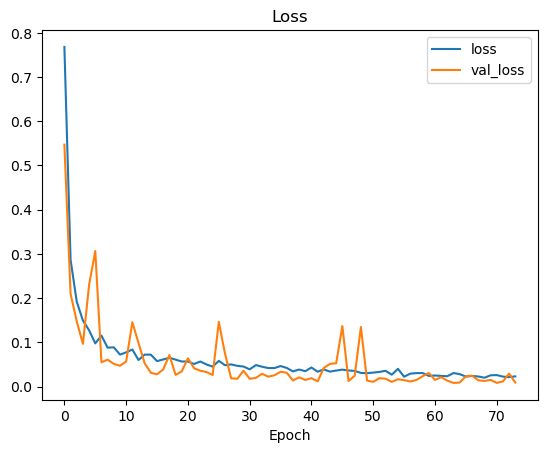

In [17]:
model_loss = pd.DataFrame(rae_model.history.history)
model_loss.plot()
pl.title('Loss')
pl.xlabel('Epoch')
pl.savefig('loss.png')
pl.show()